<a name="composites_and_shapefiles_top"></a>

# Cloud-Filtered Mosaics and Shapefile Region Selection

<hr>

This notebook can be used to create Landsat cloud-filtered mosaics for any time period and location. Selecting regions with shapefiles is also demonstrated. The mosaics can be output as GeoTIFF products for analysis in external GIS tools. 

The following mosaics are possible:
* Median = midpoint of spectral data
* Geomedian = Australian median product with improved spectral consistency
* Most-Recent = most recent clear pixel
* Least-Recent = least recent clear pixel
* Max-NDVI = maximum vegetation response
* Min-NDVI = minimum vegetation response

Users should review the "Cloud_Statistics" notebook for more information about the cloud statistics for any given temporal and spatial combination. An understanding of the underlying data is important for creating a valid mosaic for further analyses.

<hr>

# Index

* [Import Dependencies and Connect to the Data Cube](#composites_and_shapefiles_import)
* [Choose Platform and Product](#composites_and_shapefiles_plat_prod)
* [Define the Extents of the Analysis](#composites_and_shapefiles_define_extents)
* [Get the Regions Bounded by the Shapefiles](#composites_and_shapefiles_shapefiles_region_bounded)
* [Specify the Shapefile Region and Time Range to Load](#composites_and_shapefiles_shapefiles_region_select)
* [Load the Data and Create the Composite](#composites_and_shapefiles_retrieve_data)
* [Visualize the Composite](#composites_and_shapefiles_visualize_composite)
* [Export to GeoTIFF](#composites_and_shapefiles_export_to_geotiff)

## <a id="composites_and_shapefiles_import"></a>Import Dependencies and Connect to the Data Cube [&#9652;](#composites_and_shapefiles_top)

In [1]:
import sys
import os
sys.path.append(os.environ.get('NOTEBOOK_ROOT'))

import matplotlib.pyplot as plt
%matplotlib inline

# Import Data Cube API
import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi()
dc = api.dc

## <span id="composites_and_shapefiles_plat_prod">Choose Platform and Product [&#9652;](#composites_and_shapefiles_top)</span>

In [2]:
# CHANGE HERE >>>>>>>>>>>>>>>>>

# Select a Product and Platform
# Examples: ghana, kenya, tanzania, sierra_leone, senegal

product = "ls8_lasrc_ghana"
platform = "LANDSAT_8"

# Specify Mosaic Parameters
# The mosaic method to use when creating the final composite.
# One of ['median', 'geomedian', 'most_recent', 'least_recent', 'max_ndvi', 'min_ndvi']
# The options 'max' and 'min' require a spectral index to be calculated.
mosaic_method = 'median'

## <span id="composites_and_shapefiles_define_extents">Define the Extents of the Analysis [&#9652;](#composites_and_shapefiles_top)</span>

In [3]:
# Get product extents
prod_extents = api.get_query_metadata(platform=platform, product=product, measurements=[])

full_lat = prod_extents['lat_extents']
print("Lat bounds:", full_lat)
full_lon = prod_extents['lon_extents']
print("Lon bounds:", full_lon)
time_extents = list(map(lambda time: time.strftime('%Y-%m-%d'), prod_extents['time_extents']))
print("Time bounds:", time_extents)

Lat bounds: (3.7730589405966173, 11.318637832619382)
Lon bounds: (-3.772789446011382, 1.8863273493593828)
Time bounds: ['2013-04-13', '2020-01-27']


In [4]:
# The code below renders a map that can be used to view the region.
from utils.data_cube_utilities.dc_display_map import display_map
display_map(full_lat, full_lon)

## <span id="composites_and_shapefiles_shapefiles_region_bounded">Get the Regions Bounded by the Shapefiles [&#9652;](#composites_and_shapefiles_top)</span>

In [5]:
import fiona
import rasterio
import rasterio.mask
from shapely.geometry import shape

input_shp_root_pth = '../data/Ghana/smallest_biggest_district/'
big_distr_shp_pth = input_shp_root_pth + 'biggest_district.shp'
sml_distr_shp_pth = input_shp_root_pth + 'smallest_district.shp'

**Showing First Shapefile Region ('biggest_district.shp')**

In [6]:
from utils.data_cube_utilities.dc_display_map import display_map
with fiona.open(big_distr_shp_pth, 'r') as src:
    # create a shapely geometry
    geometry = shape(src[0]['geometry'])

    # get the bounding box of the shapefile geometry
    latitude, longitude = [[None]*2, [None]*2]
    longitude[0], latitude[0] = geometry.bounds[0:2]
    longitude[1], latitude[1] = geometry.bounds[2:4]
display_map(latitude,longitude)

**Showing Second Shapefile Region ('smallest_district.shp')**

In [7]:
with fiona.open(sml_distr_shp_pth, 'r') as src:
    # create a shapely geometry
    geometry = shape(src[0]['geometry'])

    # get the bounding box of the shapefile geometry
    latitude, longitude = [[None]*2, [None]*2]
    longitude[0], latitude[0] = geometry.bounds[0:2]
    longitude[1], latitude[1] = geometry.bounds[2:4]
display_map(latitude,longitude)

## <span id="composites_and_shapefiles_shapefiles_region_select">Specify the Shapefile Region and Time Range to Load [&#9652;](#composites_and_shapefiles_top)</span>

In [8]:
# Path to shapefile to load data for - one of [big_distr_shp_pth, sml_distr_shp_pth].
# Note that `big_distr_shp_pth` is very resource intensive to process because it is a large area.
shp_file_pth_to_load = sml_distr_shp_pth

# Time period
time_extents = ('2017-01-01', '2017-12-31')

## <span id="composites_and_shapefiles_retrieve_data">Load the Data and Create the Composite [&#9652;](#composites_and_shapefiles_top)</span>

In [9]:
import numpy as np
import warnings

with fiona.open(shp_file_pth_to_load, 'r') as src:
    # create a shapely geometry
    # this is done for the convenience for the .bounds property only
    shp_geom = shape(src[0]['geometry'])

    # get the bounding box of the shapefile geometry
    latitude, longitude = [[None]*2, [None]*2]
    longitude[0], latitude[0] = shp_geom.bounds[0:2]
    longitude[1], latitude[1] = shp_geom.bounds[2:4]
    
    # load data for the bounding box of the shapefile geometry
    measurements = ['red', 'green', 'blue', 'pixel_qa']
    if mosaic_method in ['max_ndvi', 'min_ndvi']:
        measurements += ['nir']
    dataset = dc.load(latitude = latitude,
                      longitude = longitude,
                      platform = platform,
                      time = time_extents,
                      product = product,
                      measurements = measurements) 

    # mask out clouds and invalid data
    from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask, landsat_clean_mask_invalid
    clean_mask = (landsat_qa_clean_mask(dataset, platform) &
                 ((dataset != -9999).to_array().all('variable')) &
                  landsat_clean_mask_invalid(dataset))
    cleaned_dataset = dataset.where(clean_mask)

    # rasterize the shapefile geometry to a boolean mask
    from datacube.utils import geometry
    src_crs = src.crs_wkt if src.crs_wkt != '' else "EPSG:4326"
    crs = geometry.CRS(src_crs)
    
    first_geometry = src[0]['geometry']
    geom = geometry.Geometry(first_geometry, crs=crs)
    geobox = dataset.geobox
    shp_mask = rasterio.features.geometry_mask(
        [geom.to_crs(geobox.crs)],
        out_shape=geobox.shape,
        transform=geobox.affine,
        all_touched=True,
        invert=True)
    
# Create the final composite.
final_dataset = cleaned_dataset.where(shp_mask)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    if mosaic_method == 'median':
        from utils.data_cube_utilities.dc_mosaic import create_median_mosaic
        composite = create_median_mosaic(cleaned_dataset, clean_mask)
    elif mosaic_method == 'geomedian':
        from utils.data_cube_utilities.dc_mosaic import create_hdmedians_multiple_band_mosaic
        composite = create_hdmedians_multiple_band_mosaic(cleaned_dataset, clean_mask)
    elif mosaic_method == 'most_recent':
        from utils.data_cube_utilities.dc_mosaic import create_mosaic
        composite = create_mosaic(cleaned_dataset, clean_mask)
    elif mosaic_method == 'least_recent':
        from utils.data_cube_utilities.dc_mosaic import create_mosaic
        composite = create_mosaic(cleaned_dataset, clean_mask, reverse_time=True)
    elif mosaic_method == 'max_ndvi':
        from utils.data_cube_utilities.dc_mosaic import create_max_ndvi_mosaic
        composite = create_max_ndvi_mosaic(cleaned_dataset, clean_mask)
    elif mosaic_method == 'min_ndvi':
        from utils.data_cube_utilities.dc_mosaic import create_min_ndvi_mosaic
        composite = create_min_ndvi_mosaic(cleaned_dataset, clean_mask)
    
final_composite = composite.where(shp_mask)

## <span id="composites_and_shapefiles_visualize_composite">Visualize the Composite [&#9652;](#composites_and_shapefiles_top)</span>

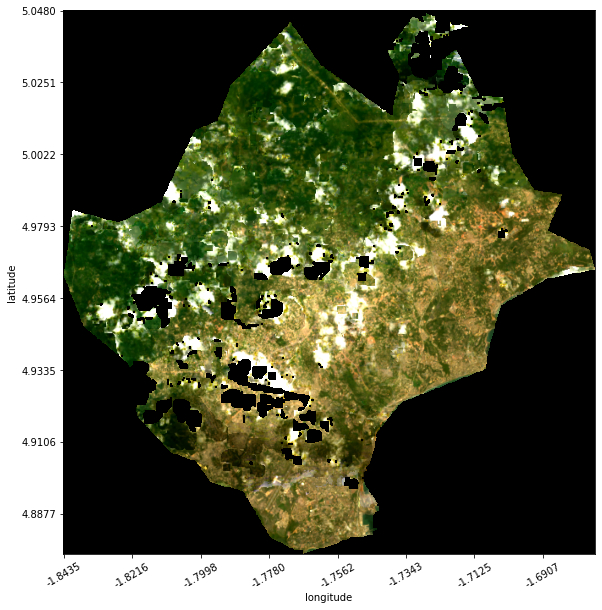

In [10]:
from utils.data_cube_utilities.dc_rgb import rgb
fig = plt.figure(figsize=(10,10))
rgb(final_composite, fig=fig)
plt.show()

## <span id="composites_and_shapefiles_export_to_geotiff">Export to GeoTIFF [&#9652;](#composites_and_shapefiles_top)</span>

In [11]:
from utils.data_cube_utilities.import_export import export_slice_to_geotiff
size_str = 'small_dist' if shp_file_pth_to_load == sml_distr_shp_pth else 'big_dist'
output_dir = 'output/geotiffs/DCAL_Custom_Mosaics_and_Shapefiles'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
export_slice_to_geotiff(composite, output_dir + '/{}_{}_composite.tif'.format(size_str, mosaic_method))

In [12]:
!ls -lah output/geotiffs/DCAL_Custom_Mosaics_and_Shapefiles

total 6.2M
drwxr-xr-x 2 jovyan users 4.0K Sep 29 00:59 .
drwxr-xr-x 4 jovyan users 4.0K Sep 28 18:15 ..
-rw-r--r-- 1 jovyan users 6.2M Sep 29 00:59 small_dist_median_composite.tif
